# Convert tiffs to eopatches

The script converts tiffs downloaded using SentinelHUb's batch API to eopatches.

In [ ]:
from abc import abstractmethod
import os
import boto3
import fs
from fs_s3fs import S3FS

from datetime import datetime, timedelta
import dateutil
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sentinelhub import CRS, BBox

from eolearn.core import FeatureType, EOPatch, EOTask, EOWorkflow, SaveTask, OverwritePermission, EOExecutor

In [2]:
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

In [3]:
date_first_batch = datetime(2019, 3, 1)
date_second_batch = datetime(2019, 6, 1)

Set up S3FS for `bucket-name`

In [4]:
filesystem = S3FS("bucket-name", 
              aws_access_key_id="",
              aws_secret_access_key="",
              region="eu-central-1")

Load tile correspondence between batch processes

In [3]:
tile_correspondence = gpd.read_file('../../input-data/tiles-correspondence.geojson')
tile_correspondence.head()

,id_left,requestId_left,geojson_left,status_left,cost_left,index_right,id_right,requestId_right,geojson_right,status_right,cost_right,eopatch_name,geometry
0,1702790,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,139.872230,0,1703758,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,203.450516,eopatch-0000,"POLYGON ((20.68052 55.85511, 20.67978 55.94496..."
1,1702791,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,133.514401,1,1703759,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,193.913773,eopatch-0001,"POLYGON ((20.68125 55.76526, 20.68052 55.85511..."
2,1702792,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,127.156572,2,1703760,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,184.377030,eopatch-0002,"POLYGON ((20.68198 55.67541, 20.68125 55.76526..."
3,1702793,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,127.156572,3,1703761,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,184.377030,eopatch-0003,"POLYGON ((20.68343 55.49570, 20.68271 55.58555..."
4,1702794,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,127.156572,4,1703762,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,184.377030,eopatch-0004,"POLYGON ((20.68415 55.40584, 20.68343 55.49570..."


In [6]:
if 'eopatch_name' not in tile_correspondence.columns:
    tile_correspondence['eopatch_name'] = tile_correspondence['index_right'].apply(lambda rowid: f'eopatch-{rowid:04d}')
    tile_correspondence.to_file('../../input-data/tiles-correspondence.geojson', driver='GeoJSON')

In [7]:
tile_correspondence.head()

,id_left,requestId_left,geojson_left,status_left,cost_left,index_right,id_right,requestId_right,geojson_right,status_right,cost_right,eopatch_name,geometry
0,1702790,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,139.872230,0,1703758,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,203.450516,eopatch-0000,"POLYGON ((20.68051539589089 55.85510943895299,..."
1,1702791,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,133.514401,1,1703759,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,193.913773,eopatch-0001,"POLYGON ((20.68125049177392 55.76525859960496,..."
2,1702792,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,127.156572,2,1703760,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,184.377030,eopatch-0002,"POLYGON ((20.68198143407777 55.67540643163385,..."
3,1702793,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,127.156572,3,1703761,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,184.377030,eopatch-0003,"POLYGON ((20.68343098588699 55.49569810341387,..."
4,1702794,964d90b7-41a7-4025-a392-140ae5236bf5,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,127.156572,4,1703762,ab0442c1-6c27-4bec-a798-8953ad955698,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",PROCESSED,184.377030,eopatch-0004,"POLYGON ((20.68414965852928 55.40584193999174,..."


In [8]:
class BaseLocalIo(EOTask):
    """ Base abstract class for local IO tasks
    """
    def __init__(self, feature, filesystem, folder=None, *, image_dtype=None, no_data_value=0):
        """
        :param feature: Feature which will be exported or imported
        :type feature: (FeatureType, str)
        :param folder: A directory containing image files or a path of an image file
        :type folder: str
        :param image_dtype: Type of data to be exported into tiff image or imported from tiff image
        :type image_dtype: numpy.dtype
        :param no_data_value: Value of undefined pixels
        :type no_data_value: int or float
        """
        self.feature = self._parse_features(feature)
        self.filesystem = filesystem
        self.folder = folder
        self.image_dtype = image_dtype
        self.no_data_value = no_data_value

    def _get_file_path(self, filename, create_dir=False):
        """ Builds a file path from values obtained at class initialization and in execute method.
        If create_dir is set to True, non existing directories are automatically created.
        """
        if self.folder is None:
            if filename is None:
                raise ValueError("At least one of parameters 'folder' and 'filename' has to be specified")
            path = filename
        elif filename is None:
            path = self.folder
        else:
            path = fs.path.combine(self.folder, filename)

        # Create directory of path if it doesn't exist
        if create_dir:
            path_dir = fs.path.dirname(path)
            if path_dir != '' and not filesystem.exists(path_dir):
                filesystem.makedirs(path_dir, recreate=True)

        return path

    @abstractmethod
    def execute(self, eopatch, **kwargs):
        """ Execute of a base class is not implemented
        """
        raise NotImplementedError
        

class ImportFromAWSTiff(BaseLocalIo):
    """ Task for importing data from a Geo-Tiff file into an EOPatch
    The task can take an existing EOPatch and read the part of Geo-Tiff image, which intersects with its bounding
    box, into a new feature. But if no EOPatch is given it will create a new EOPatch, read entire Geo-Tiff image into a
    feature and set a bounding box of the new EOPatch.
    Note that if Geo-Tiff file is not completely spatially aligned with location of given EOPatch it will try to fit it
    as best as possible. However it will not do any spatial resampling or interpolation on Geo-TIFF data.
    """
    def __init__(self, feature, filesystem, folder=None, *, timestamp_size=None, **kwargs):
        """
        :param feature: EOPatch feature into which data will be imported
        :type feature: (FeatureType, str)
        :param folder: A directory containing image files or a path of an image file
        :type folder: str
        :param timestamp_size: In case data will be imported into time-dependant feature this parameter can be used to
            specify time dimension. If not specified, time dimension will be the same as size of FeatureType.TIMESTAMP
            feature. If FeatureType.TIMESTAMP does not exist it will be set to 1.
            When converting data into a feature channels of given tiff image should be in order
            T(1)B(1), T(1)B(2), ..., T(1)B(N), T(2)B(1), T(2)B(2), ..., T(2)B(N), ..., ..., T(M)B(N)
            where T and B are the time and band indices.
        :type timestamp_size: int
        :param image_dtype: Type of data of new feature imported from tiff image
        :type image_dtype: numpy.dtype
        :param no_data_value: Values where given Geo-Tiff image does not cover EOPatch
        :type no_data_value: int or float
        """
        super().__init__(feature, filesystem=filesystem, folder=folder, **kwargs)

        self.timestamp_size = timestamp_size

    @staticmethod
    def _get_reading_window(width, height, data_bbox, eopatch_bbox):
        """ Calculates a window in pixel coordinates for which data will be read from an image
        """
        if eopatch_bbox.crs is not data_bbox.crs:
            eopatch_bbox = eopatch_bbox.transform(data_bbox.crs)

        # The following will be in the future moved to sentinelhub-py
        data_ul_x, data_lr_y = data_bbox.lower_left
        data_lr_x, data_ul_y = data_bbox.upper_right

        res_x = abs(data_ul_x - data_lr_x) / width
        res_y = abs(data_ul_y - data_lr_y) / height

        ul_x, lr_y = eopatch_bbox.lower_left
        lr_x, ul_y = eopatch_bbox.upper_right

        # If these coordinates wouldn't be rounded here, rasterio.io.DatasetReader.read would round
        # them in the same way
        top = round((data_ul_y - ul_y) / res_y)
        left = round((ul_x - data_ul_x) / res_x)
        bottom = round((data_ul_y - lr_y) / res_y)
        right = round((lr_x - data_ul_x) / res_x)

        return (top, bottom), (left, right)

    def execute(self, eopatch=None, *, filename=None):
        """ Execute method which adds a new feature to the EOPatch
        :param eopatch: input EOPatch or None if a new EOPatch should be created
        :type eopatch: EOPatch or None
        :param filename: filename of tiff file or None if entire path has already been specified in `folder` parameter
            of task initialization.
        :type filename: str or None
        :return: New EOPatch with added raster layer
        :rtype: EOPatch
        """
        feature_type, feature_name = next(self.feature())
        if eopatch is None:
            eopatch = EOPatch()

        session = boto3.Session(aws_access_key_id=self.filesystem.aws_access_key_id, 
                                aws_secret_access_key=self.filesystem.aws_secret_access_key,
                                region_name=self.filesystem.region) 
        
        with rasterio.Env(rasterio.session.AWSSession(session)) as env:
            s3_url = f's3://{self.filesystem._bucket_name}/{self._get_file_path(filename)}'
#             print(s3_url)
            with rasterio.open(s3_url) as source:

                data_bbox = BBox(source.bounds, CRS(source.crs.to_epsg()))
                if eopatch.bbox is None:
                    eopatch.bbox = data_bbox

                reading_window = self._get_reading_window(source.width, source.height, data_bbox, eopatch.bbox)

                data = source.read(window=reading_window, boundless=True, fill_value=self.no_data_value)

        if self.image_dtype is not None:
            data = data.astype(self.image_dtype)

        if not feature_type.is_spatial():
            data = data.flatten()

        if feature_type.is_timeless():
            data = np.moveaxis(data, 0, -1)
        else:
            channels = data.shape[0]

            times = self.timestamp_size
            if times is None:
                times = len(eopatch.timestamp) if eopatch.timestamp else 1

            if channels % times != 0:
                raise ValueError('Cannot import as a time-dependant feature because the number of tiff image channels '
                                 'is not divisible by the number of timestamps')

            data = data.reshape((times, channels // times) + data.shape[1:])
            data = np.moveaxis(data, 1, -1)

        eopatch[feature_type][feature_name] = data

        return eopatch

    
class RearrangeTime(EOTask):
    """ rearrange channels as time and  """
    def __init__(self, reference_date, band_names, clp_name='CLP', is_data_name='dataMask', count_name='count'):
        self.reference_date = reference_date
        self.band_names = band_names
        self.clp_name = clp_name
        self.is_data_name = is_data_name
        self.count_name = count_name
        
    def execute(self, eopatch):
        h, w, c = eopatch.data_timeless[self.band_names[0]].shape
        # assume all bands have same number of valid acquisitions
        valid_doys = np.where(np.mean(eopatch.data_timeless[self.band_names[0]], axis=(0,1)))[0]
        
        band_list = [np.moveaxis(eopatch.data_timeless[band_name][..., valid_doys], -1, 0)[..., np.newaxis] 
                     for band_name in self.band_names]
        
        eopatch.data['BANDS'] = np.concatenate(band_list, axis=-1)
        eopatch.data[self.clp_name] = np.moveaxis(eopatch.data_timeless[self.clp_name][..., valid_doys], -1, 0)[..., np.newaxis]
        eopatch.mask['IS_DATA'] = np.moveaxis(eopatch.data_timeless[self.is_data_name][..., valid_doys], -1, 0)[..., np.newaxis]
        eopatch.scalar_timeless['COUNT_TIMES'] = np.unique(eopatch.data_timeless[self.count_name])
        
        for feature_name in self.band_names+[self.clp_name, self.is_data_name, self.count_name]:
            del eopatch.data_timeless[feature_name]

        # add timestamps
        eopatch.timestamp = [self.reference_date+timedelta(days=int(doy)) for doy in valid_doys]
        
#         assert eopatch.scalar_timeless['COUNT_TIMES'].size == 1
#         assert eopatch.scalar_timeless['COUNT_TIMES'] == len(eopatch.timestamp)
        
        return eopatch
    

class TemporalConcatenationTask(EOTask):
    """ Task to concatenate temporally a list of eopatches

    Only the DATA and MASK features are concatenated. The task assumes all patches contain the same features
    """
    def __init__(self, time_periods):
        """ Time periods will be sorted, assuming the 'YEAR/QX' format.

        :param time_periods: List of time periods to be concatenated, such as ['2018/Q4', '2019/Q1', '2019/Q2']
        :type time_periods: list of str
        :return: EOPatch with temporally concatenated arrays
        """
        self.time_periods = sorted(time_periods)
        self.time_indices = sorted(range(len(time_periods)), key=lambda k: time_periods[k])

    def execute(self, *eopatches):
        """ Sort patches temporally according to time_periods and concatenate starting from first """
        # sort list of eopatches according to provided time indices, e.g. eop_2019_q1, eop_2019_q2, eop_2019_q3
        eopatches = [eopatches[tidx] for tidx in self.time_indices]
        # get a list of timestamps of sorted eopatches. Timestamps are lists, so this is a list of lists
        timestamp_list = [eop.timestamp for eop in eopatches]
        # this mask finds dates in the next time period that are the same as the previous time period. The first
        # loop iterationloop will return (2019_q1_datetimes, 2019_q2_datetimes) and find the dates in 2019_q2 that match
        # the dates in 2019_q1. These will be ignored when concatenating 2019_q2
        masks = [np.isin(time_post, list(set(time_post).difference(set(time_pre))))
                 for time_pre, time_post in zip(timestamp_list[:-1], timestamp_list[1:])]
        # create concatenated timestamp by removing duplicated dates in trailing time periods
        timestamp = eopatches[0].timestamp + [tstamp for eop, mask in zip(eopatches[1:], masks)
                                              for tstamp, to_keep in zip(eop.timestamp, mask) if to_keep]
        # sort time periods in case the two sequences had a different time_difference
        sorted_indices = sorted(range(len(timestamp)), key=lambda k: timestamp[k])

        eop = EOPatch(bbox=eopatches[0].bbox, timestamp=sorted(timestamp))

        # TODO: add SCALAR
        # TODO: add check so that only features contained by all patches are concatenated
        for feature_type in [FeatureType.DATA, FeatureType.MASK]:
            for feature_name in eopatches[0][feature_type].keys():
                feat = (feature_type, feature_name)
                array = np.concatenate((eopatches[0][feat],
                                        *[eop[feat][mask] for eop, mask in zip(eopatches[1:], masks)]), axis=0)
                eop[feat] = array[sorted_indices]

        eop.meta_info['time_interval'] = (eop.timestamp[0].date().isoformat(),
                                          eop.timestamp[-1].date().isoformat())

        eop.meta_info['info'] = 'Temporally concatenated from {}'.format(' '.join(self.time_periods))
        
        bboxes = [eopatch.bbox for eopatch in eopatches]
        assert all([bboxes[0] == bbox for bbox in bboxes[1:]])

        return eop


Get IDs for first and second batch

In [9]:
request_id_left = tile_correspondence.iloc[0].requestId_left
request_id_right = tile_correspondence.iloc[0].requestId_right

Set names of TIFFs to read in

In [10]:
tiffs = ['B02.tif','B03.tif','B04.tif','B08.tif','CLP.tif','count.tif','dataMask.tif']

Initialise tasks to import tiffs for first batch process

In [11]:
left_tasks = [(ImportFromAWSTiff((FeatureType.DATA_TIMELESS, bands.split('.')[0]), 
                                   filesystem, 
                                   folder=f'{request_id_left}/'), f'left_import_{nband}') 
                for nband, bands in enumerate(tiffs)]
left_tasks.append((RearrangeTime(reference_date=date_first_batch, 
                                 band_names=['B02', 'B03', 'B04', 'B08']), f'left_rearrange'))

Initialise tasks to import tiffs for second batch process

In [12]:
right_tasks = [(ImportFromAWSTiff((FeatureType.DATA_TIMELESS, bands.split('.')[0]), 
                                   filesystem, 
                                   folder=f'{request_id_right}/'), f'right_import_{nband}') 
                for nband, bands in enumerate(tiffs)]
right_tasks.append((RearrangeTime(reference_date=date_second_batch, 
                                 band_names=['B02', 'B03', 'B04', 'B08']), f'right_rearrange'))

Combine tasks into a single workflow, introducing dependencies to previous task

In [13]:
task_list = []
for tasks in [left_tasks, right_tasks]:
    last_task = []
    for task, task_name in tasks:
        previous_task = [last_task] if last_task else []
        task_list.append((task, previous_task, task_name))
        last_task = task

Append task for joining patches for first and second trimester

In [14]:
concatenate_task = TemporalConcatenationTask(['2019/03', '2019/06'])
task_list.append((concatenate_task, 
                  [left_tasks[-1][0], right_tasks[-1][0]], 
                  'concatenate'))

Append task for saving resulting patch

In [15]:
task_list.append((SaveTask(path='data/Lithuania/eopatches/2019/', 
                           filesystem=filesystem, 
                           overwrite_permission=OverwritePermission.OVERWRITE_PATCH), 
                  [concatenate_task], 
                  'Save EOPatch'))

In [17]:
workflow = EOWorkflow(task_list)

Build list of inputs for execution

In [18]:
exec_args = []
tasks = workflow.get_tasks()

for nrow, row, in tqdm(tile_correspondence.iterrows(), total=len(tile_correspondence)):

    single_exec_dict = {}

    for task_name, task in tasks.items():
        if isinstance(task, ImportFromAWSTiff):
            band_idx = int(task_name.split('_')[-1])
            tile_id = row.id_left if 'left' in task_name else row.id_right
            single_exec_dict[task] = dict(filename=f'{tile_id}/{tiffs[band_idx]}')

        if isinstance(task, SaveTask):
            single_exec_dict[task] = dict(eopatch_folder=f'{row.eopatch_name}')

    exec_args.append(single_exec_dict)


In [19]:
tile_correspondence.iloc[591]

id_left                                                      1703381
requestId_left                  964d90b7-41a7-4025-a392-140ae5236bf5
geojson_left       {'type': 'Polygon', 'crs': {'type': 'name', 'p...
status_left                                                PROCESSED
cost_left                                                    139.872
index_right                                                      591
id_right                                                     1704349
requestId_right                 ab0442c1-6c27-4bec-a798-8953ad955698
geojson_right      {'type': 'Polygon', 'crs': {'type': 'name', 'p...
status_right                                               PROCESSED
cost_right                                                   165.304
eopatch_name                                            eopatch-0591
geometry           POLYGON ((24.30466953699019 55.55632381177488,...
Name: 591, dtype: object

Test workflow on a single eopatch

In [21]:
eop = workflow.execute(exec_args[591])

In [22]:
eop = list(eop.values())[0]

In [23]:
eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 1000, 1000, 4), dtype=uint16)
    CLP: numpy.ndarray(shape=(25, 1000, 1000, 1), dtype=uint8)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(25, 1000, 1000, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    count: numpy.ndarray(shape=(1000, 1000, 1), dtype=uint16)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((330000.0, 6160000.0), (340000.0, 6170000.0)), crs=CRS('32635'))
  timestamp: [datetime.datetime(2019, 3, 6, 0, 0), ..., datetime.datetime(2019, 5, 30, 0, 0)], length=25
)

In [24]:
eop.scalar_timeless['COUNT_TIMES']

array([19, 25], dtype=uint16)

In [27]:
eop.timestamp

[datetime.datetime(2019, 3, 6, 0, 0),
 datetime.datetime(2019, 3, 8, 0, 0),
 datetime.datetime(2019, 3, 18, 0, 0),
 datetime.datetime(2019, 3, 23, 0, 0),
 datetime.datetime(2019, 3, 31, 0, 0),
 datetime.datetime(2019, 4, 2, 0, 0),
 datetime.datetime(2019, 4, 5, 0, 0),
 datetime.datetime(2019, 4, 7, 0, 0),
 datetime.datetime(2019, 4, 12, 0, 0),
 datetime.datetime(2019, 4, 15, 0, 0),
 datetime.datetime(2019, 4, 17, 0, 0),
 datetime.datetime(2019, 4, 20, 0, 0),
 datetime.datetime(2019, 4, 22, 0, 0),
 datetime.datetime(2019, 4, 25, 0, 0),
 datetime.datetime(2019, 4, 27, 0, 0),
 datetime.datetime(2019, 4, 30, 0, 0),
 datetime.datetime(2019, 5, 7, 0, 0),
 datetime.datetime(2019, 5, 10, 0, 0),
 datetime.datetime(2019, 5, 12, 0, 0),
 datetime.datetime(2019, 5, 15, 0, 0),
 datetime.datetime(2019, 5, 17, 0, 0),
 datetime.datetime(2019, 5, 20, 0, 0),
 datetime.datetime(2019, 5, 22, 0, 0),
 datetime.datetime(2019, 5, 25, 0, 0),
 datetime.datetime(2019, 5, 30, 0, 0)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


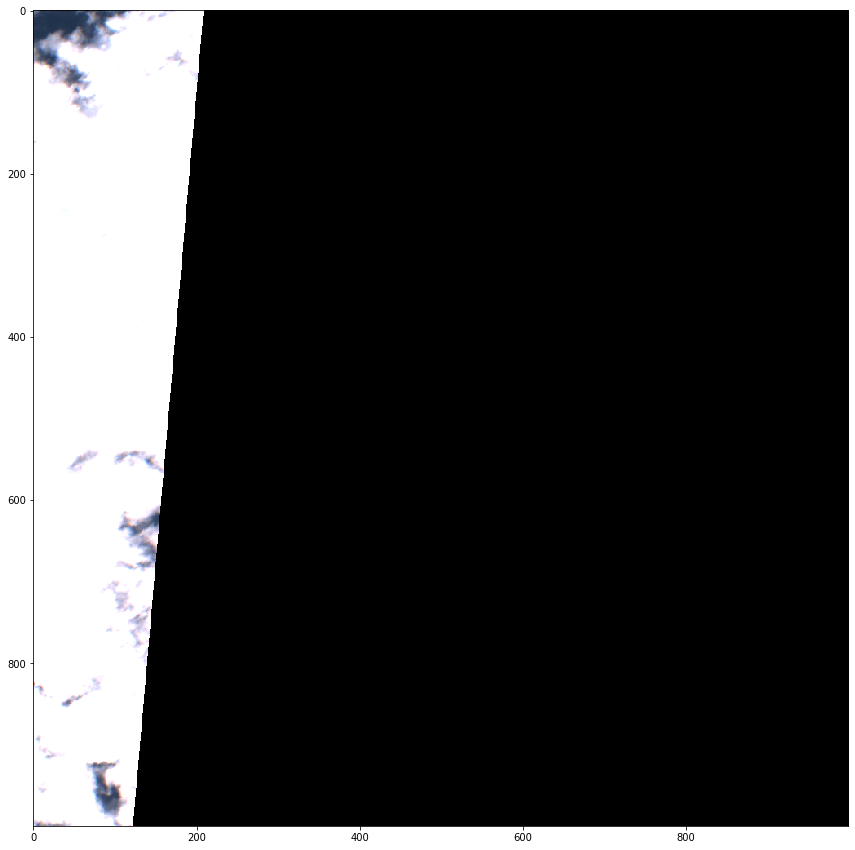

In [26]:
tidx = 4

plt.figure(figsize=(15,15))
plt.imshow(2.5*eop.data['BANDS'][tidx][..., [2,1,0]]/10000)
# plt.imshow(eop.data['CLP'][tidx][..., 0]/255, vmin=0, vmax=1, alpha=.4)

Run on all eopatches in parallel

In [ ]:
MAX_WORKERS = 16

executor = EOExecutor(workflow, exec_args, save_logs=True, logs_folder='.')

executor.run(workers=MAX_WORKERS)

In [ ]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))